# Robotic Arm Planner: Training and Evaluation Demo

This notebook demonstrates the training and evaluation process for the robotic arm planner models (`ANN` and `GLE`). 

We will perform the following steps:
1. **Setup**: Import libraries and configure paths.
2. **Configuration**: Set the model type and other parameters.
3. **Data Loading**: Load and visualize the dataset.
4. **Training**: Train the selected model.
5. **Evaluation**: Evaluate the trained model's performance on the dataset.
6. **Result Visualization**: Plot trajectories predicted by the model against the ground truth.

## 1. Setup

First, let's import the necessary libraries and modules. We also define the `get_project_root` function to correctly locate our data, models, and results directories.

In [1]:
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming the notebook is in the parent directory of the submodule or project
from src.planners import ANNPlanner, GLEPlanner, ANNPlannerNet, GLEPlannerNet
from src.dataset import RobotArmDataset
from src.config import default_params

# Setup Paths
from src.train import get_project_root
PROJECT_ROOT = get_project_root()
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data will be read from: {DATA_DIR}")
print(f"Models will be saved to: {MODELS_DIR}")
print(f"Results will be saved to: {RESULTS_DIR}")

Project Root: /home/paul/dev/controller/submodules/pfc_planner
Data will be read from: /home/paul/dev/controller/submodules/pfc_planner/data
Models will be saved to: /home/paul/dev/controller/submodules/pfc_planner/models
Results will be saved to: /home/paul/dev/controller/submodules/pfc_planner/results


/home/paul/dev/controller/submodules/pfc_planner/src/dataset.py:26: UserWarning: Controller import failed: Controller path '/sim/controller/complete_control' not found or not a directory.. Using local fallback implementation.
  warnings.warn(f"Controller import failed: {e}. Using local fallback implementation.")


## 2. Configuration

Here you can configure the training run. The most important parameter is `model_type`. You can choose between `'ann'` and `'gle'`.

In [2]:
params = default_params
# Set the model type: 'ann' or 'gle'
params.model_type = 'ann'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"--- Configuration ---")
print(f"Model Type: {params.model_type.upper()}")
print(f"Device: {device}")
print(f"Number of Epochs: {params.num_epochs}")
print(f"Learning Rate: {params.learning_rate}")
print(f"Image Size: {params.image_size}")

--- Configuration ---
Model Type: ANN
Device: cpu
Number of Epochs: 500
Learning Rate: 0.01
Image Size: (100, 100)


## 3. Data Loading and Visualization

We load the dataset using `RobotArmDataset`. Then, we'll visualize a few samples from the dataset to understand what the model will be working with.

Loaded 32 samples. Trajectory length: 1500

Visualizing a few data samples...


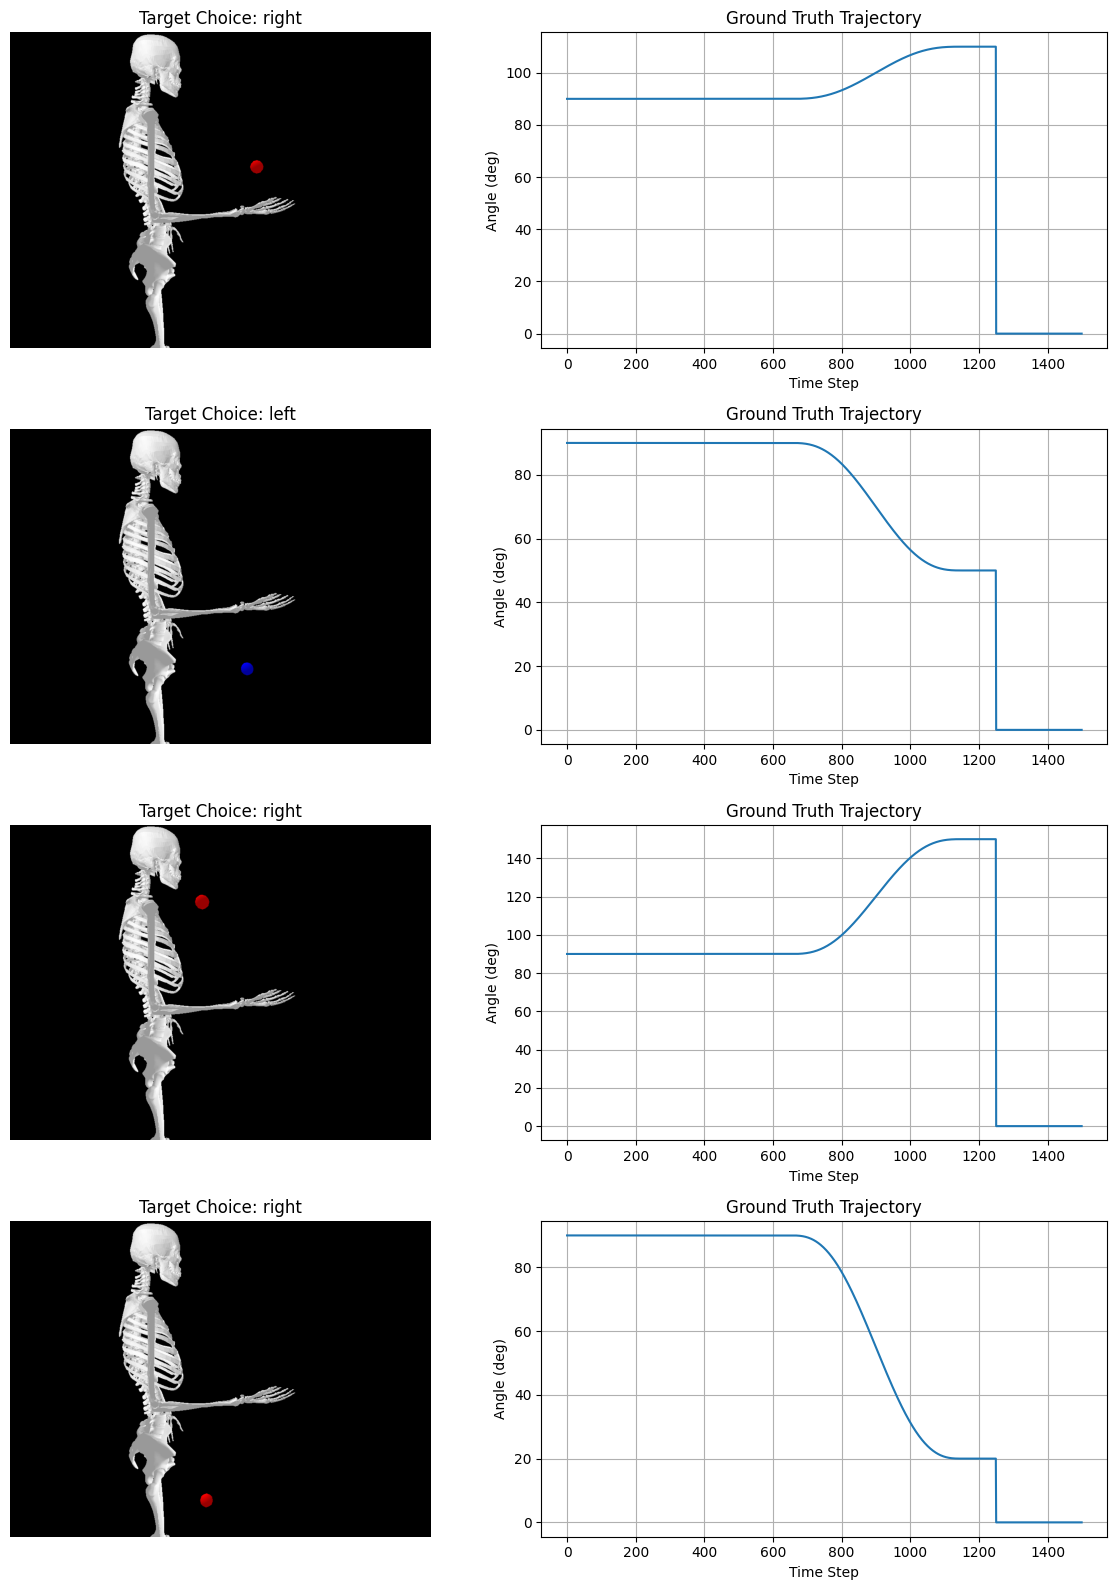

In [3]:
dataset = RobotArmDataset(data_dir=str(DATA_DIR), params=params, transform=transforms.Compose([
    transforms.Resize(params.image_size), transforms.ToTensor()
]))

if len(dataset) == 0:
    sys.exit(f"ERROR: No data found in {DATA_DIR}. Exiting.")

print(f"Loaded {len(dataset)} samples. Trajectory length: {params.trajectory_length}")

# --- Visualize a few data samples ---
print("\nVisualizing a few data samples...")
num_samples_to_show = min(len(dataset), 4)
fig, axes = plt.subplots(num_samples_to_show, 2, figsize=(12, 4 * num_samples_to_show))
if num_samples_to_show == 1: axes = [axes] # make it iterable

for i in range(num_samples_to_show):
    item = dataset.task_data[i]
    image = Image.open(item['image_path'])
    trajectory_rad = item['ground_truth_trajectory_rad']
    choice = item['target_choice']

    # Plot image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Target Choice: {choice}")
    axes[i, 0].axis('off')

    # Plot trajectory
    axes[i, 1].plot(np.rad2deg(trajectory_rad))
    axes[i, 1].set_title("Ground Truth Trajectory")
    axes[i, 1].set_xlabel("Time Step")
    axes[i, 1].set_ylabel("Angle (deg)")
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()

## 4. Training

Now we'll train the model. We create a DataLoader, initialize the network, optimizer, and loss functions, and then run the training loop.


--- Starting Training for ANN Planner ---
Training on device 'cpu'...
Epoch   1/500 | Total Loss: 2.701767 | Traj Loss: 2.008259 | Choice Loss: 0.693509
Epoch  10/500 | Total Loss: 1.077263 | Traj Loss: 0.384771 | Choice Loss: 0.692492
Epoch  20/500 | Total Loss: 0.883727 | Traj Loss: 0.186501 | Choice Loss: 0.697227
Epoch  30/500 | Total Loss: 0.823833 | Traj Loss: 0.141091 | Choice Loss: 0.682743
Epoch  40/500 | Total Loss: 0.800574 | Traj Loss: 0.128163 | Choice Loss: 0.672411
Epoch  50/500 | Total Loss: 0.768810 | Traj Loss: 0.122794 | Choice Loss: 0.646016
Epoch  60/500 | Total Loss: 0.690264 | Traj Loss: 0.120187 | Choice Loss: 0.570077
Epoch  70/500 | Total Loss: 0.509678 | Traj Loss: 0.117037 | Choice Loss: 0.392641
Epoch  80/500 | Total Loss: 0.343912 | Traj Loss: 0.112433 | Choice Loss: 0.231480
Epoch  90/500 | Total Loss: 0.250394 | Traj Loss: 0.103199 | Choice Loss: 0.147195
Epoch 100/500 | Total Loss: 0.192060 | Traj Loss: 0.089624 | Choice Loss: 0.102436
Epoch 110/500 | 

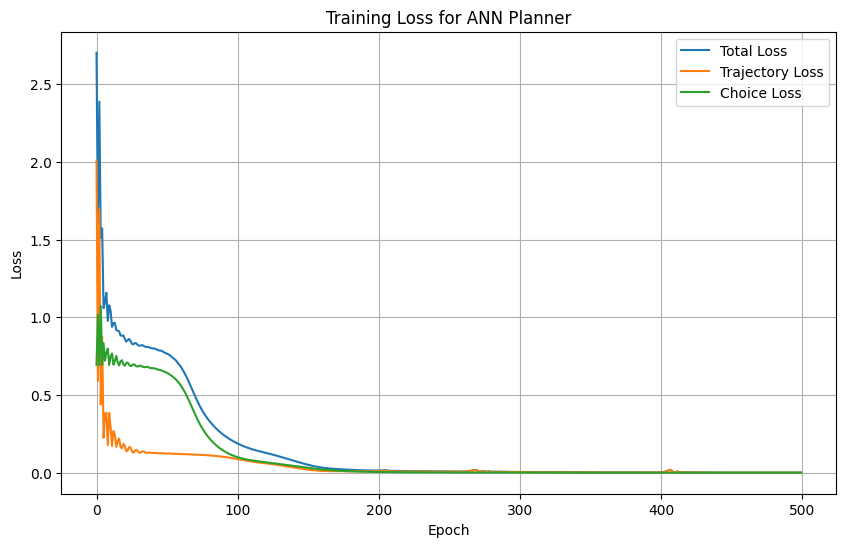

In [4]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=True)

if params.model_type == 'ann':
    net = ANNPlannerNet(params=params)
    planner = ANNPlanner(params=params, net=net)
else: # gle
    net = GLEPlannerNet(params=params)
    planner = GLEPlanner(params=params, net=net)

optimizer = optim.Adam(net.parameters(), lr=params.learning_rate)
criterion_trajectory = nn.MSELoss()
criterion_choice = nn.CrossEntropyLoss()

loss_history, traj_loss_history, choice_loss_history = [], [], []

print(f"\n--- Starting Training for {params.model_type.upper()} Planner ---")
print(f"Training on device '{device}'...")

for epoch in range(params.num_epochs):
    net.train()
    running_loss, running_traj_loss, running_choice_loss = 0.0, 0.0, 0.0

    for images, true_trajectory, target_choice_idx in train_loader:
        images, true_trajectory, target_choice_idx = images.to(device), true_trajectory.to(device), target_choice_idx.to(device)
        optimizer.zero_grad()

        if params.model_type == 'ann':
            output = net(images)
            trajectory_loss = criterion_trajectory(output[:, :params.trajectory_length], true_trajectory)
            choice_loss = criterion_choice(output[:, params.trajectory_length:], target_choice_idx)
            total_loss = trajectory_loss + choice_loss
            total_loss.backward()
            optimizer.step()
        else: # gle
            target = torch.cat((true_trajectory, torch.nn.functional.one_hot(target_choice_idx, num_classes=params.num_choices)), dim=1)
            for _ in range(params.gle_update_steps):
                output = net(images, target, beta=params.gle_beta)
            optimizer.step()
            trajectory_loss = criterion_trajectory(output[:, :params.trajectory_length], true_trajectory)
            choice_loss = criterion_choice(output[:, params.trajectory_length:], target_choice_idx)
            total_loss = trajectory_loss + choice_loss

        running_loss += total_loss.item()
        running_traj_loss += trajectory_loss.item()
        running_choice_loss += choice_loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_traj_loss = running_traj_loss / len(train_loader)
    epoch_choice_loss = running_choice_loss / len(train_loader)

    loss_history.append(epoch_loss); traj_loss_history.append(epoch_traj_loss); choice_loss_history.append(epoch_choice_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1: >3}/{params.num_epochs} | Total Loss: {epoch_loss:.6f} | Traj Loss: {epoch_traj_loss:.6f} | Choice Loss: {epoch_choice_loss:.6f}")

print("\n--- Training Finished ---")
model_save_path = MODELS_DIR / f"trained_{params.model_type}_planner.pth"
torch.save(net.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Total Loss'); plt.plot(traj_loss_history, label='Trajectory Loss'); plt.plot(choice_loss_history, label='Choice Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'Training Loss for {params.model_type.upper()} Planner'); plt.legend(); plt.grid(True)
loss_plot_path = RESULTS_DIR / f'{params.model_type}_planner_training_loss.png'
plt.savefig(loss_plot_path)
print(f"Training plot saved to {loss_plot_path}")
plt.show()

## 5. Evaluation

With the model trained, we can now evaluate its performance. We will load the saved model and run it on the dataset to calculate choice and final angle accuracy.

--- Setting up Evaluation for ANN Planner ---
Loading model from: /home/paul/dev/controller/submodules/pfc_planner/models/trained_ann_planner.pth
Loading trained model from /home/paul/dev/controller/submodules/pfc_planner/models/trained_ann_planner.pth to device 'cpu'...

Generating predictions and calculating accuracy...
Comparing angles at index: -350 (end of movement phase)

--- Evaluation Complete ---
Choice Accuracy: 100.00%
Final Angle Accuracy (within 1.0 degree): 93.75%

Visualizing predicted trajectories with phase markers...


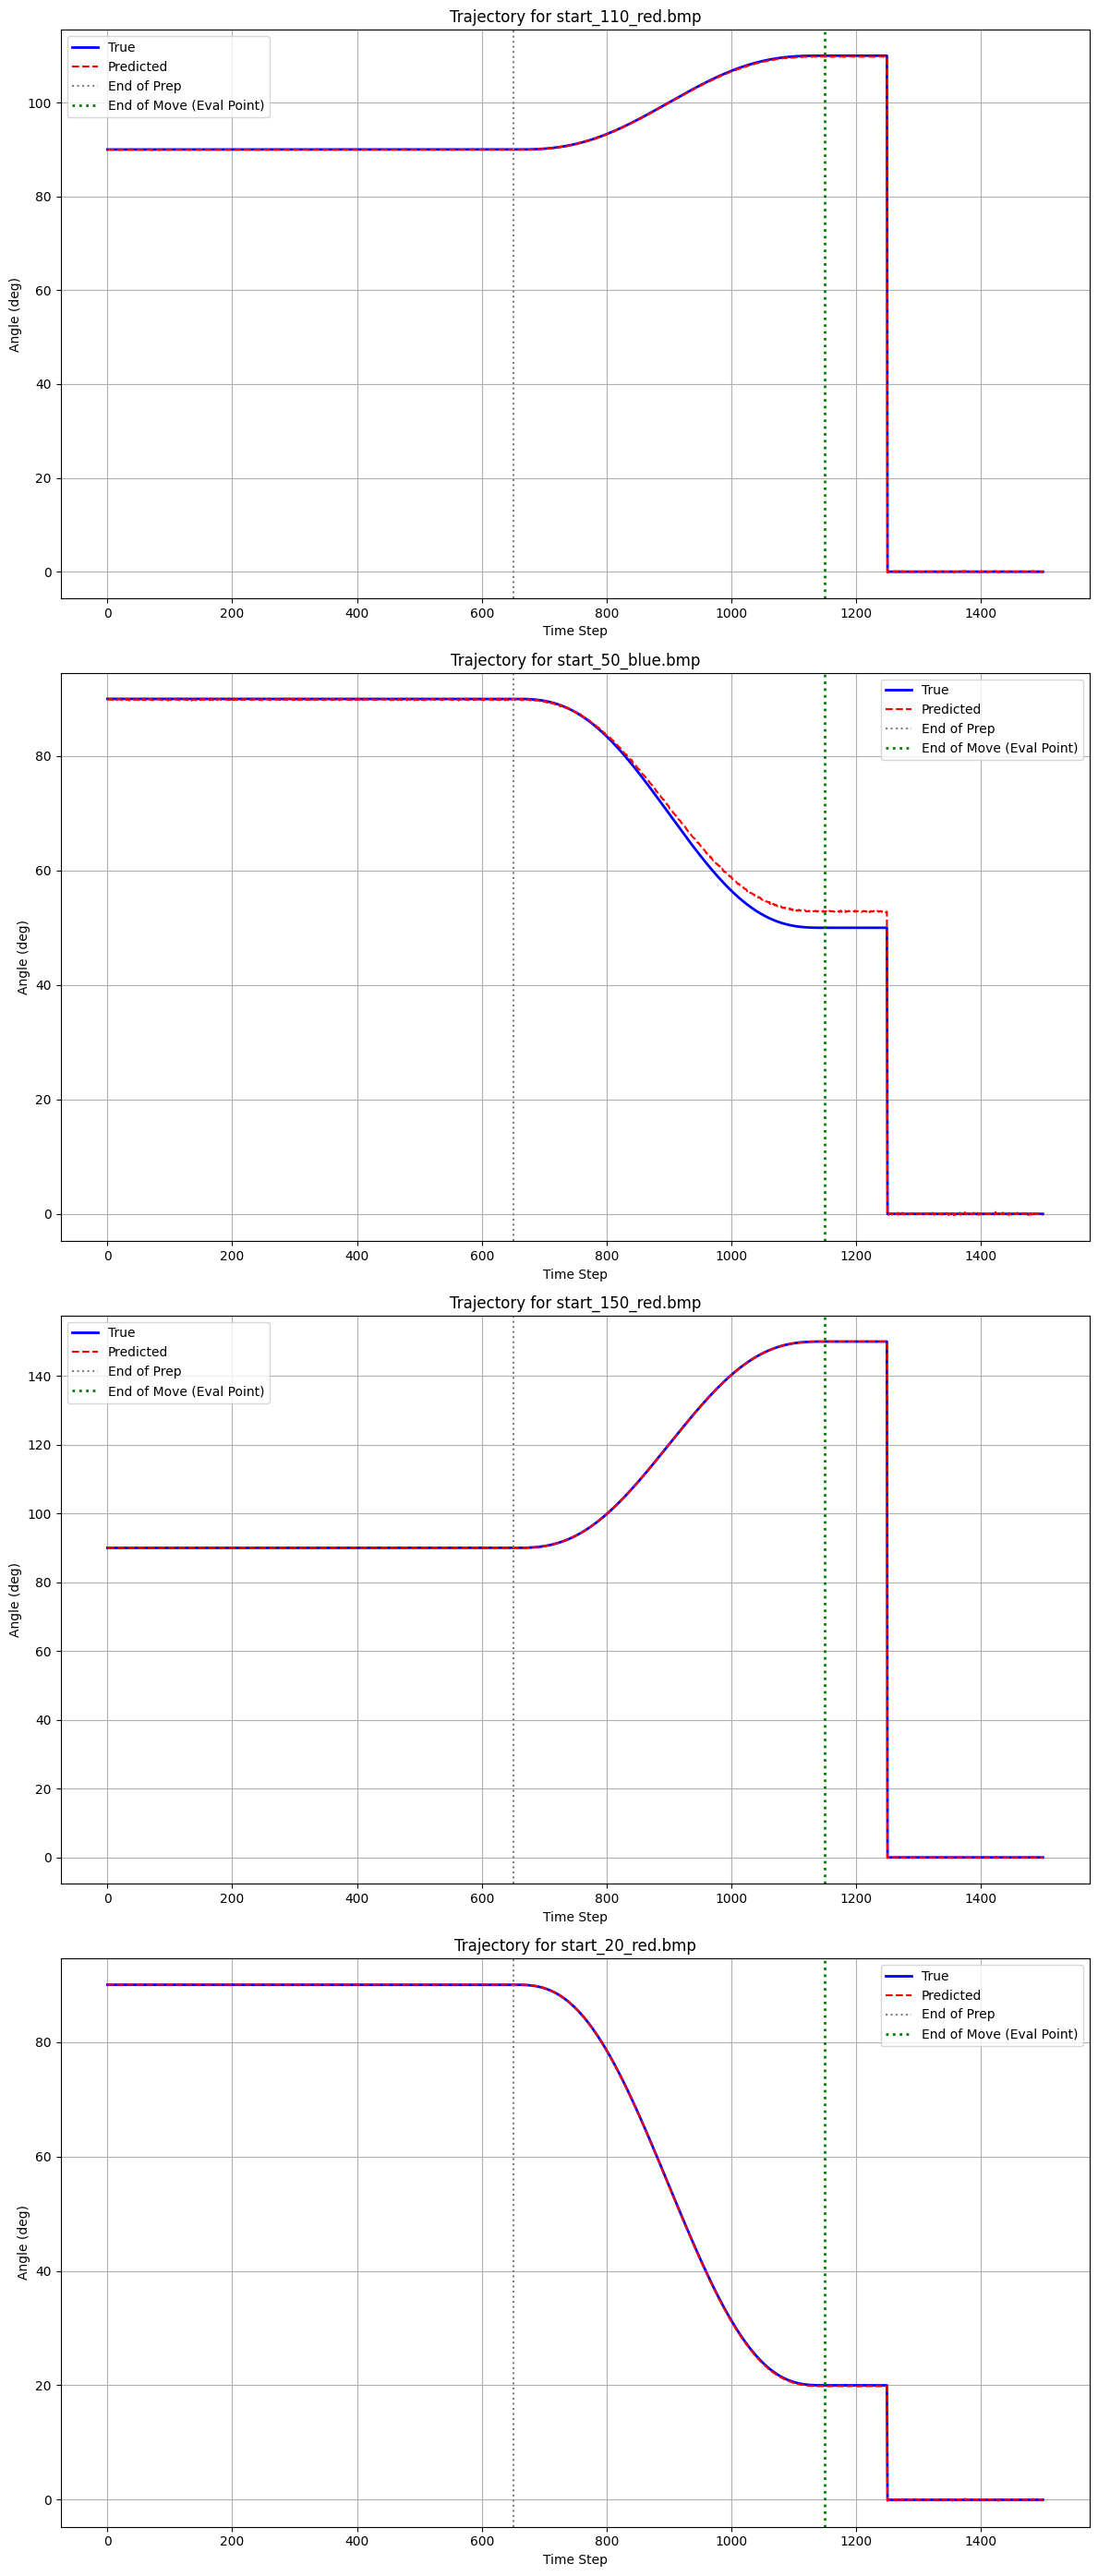


Individual trajectory plot files are also saved in '/home/paul/dev/controller/submodules/pfc_planner/results' during the main evaluation script run.


In [5]:
print(f"--- Setting up Evaluation for {params.model_type.upper()} Planner ---")

# Define model path and explicitly load the trained weights
model_path = MODELS_DIR / f"trained_{params.model_type}_planner.pth"
if not model_path.exists():
    raise FileNotFoundError(f"ERROR: Model not found at {model_path}. Please train it first.")

print(f"Loading model from: {model_path}")
planner.load_model(model_path) # This sets the `model_loaded` flag to True

print("\nGenerating predictions and calculating accuracy...")

# Calculate the index for accuracy comparison
post_phase_steps = int((params.time_grasp + params.time_post) / params.resolution)
angle_comparison_index = -post_phase_steps if post_phase_steps > 0 else -1
print(f"Comparing angles at index: {angle_comparison_index} (end of movement phase)")

correct_choices = 0
correct_angles = 0
predicted_trajectories = [] # This will be our single source of truth

# Loop through each item, generating a prediction one-by-one
# This is crucial for ensuring the state of stateful models (like GLE) is handled correctly.
for item_metadata in dataset.task_data:
    image_path = Path(item_metadata['image_path'])
    
    # Generate a single prediction
    predicted_trajectory, predicted_choice = planner.image_to_trajectory(image_path)
    predicted_trajectories.append(predicted_trajectory)

    # Perform numerical evaluation immediately
    if predicted_choice == item_metadata['target_choice']:
        correct_choices += 1
        
    pred_angle = predicted_trajectory[angle_comparison_index]
    true_angle = item_metadata['ground_truth_trajectory_rad'][angle_comparison_index]

    if np.isclose(pred_angle, true_angle, atol=np.deg2rad(1.0)):
        correct_angles += 1

# Calculate and print final accuracy scores
choice_accuracy = (correct_choices / len(dataset)) * 100
angle_accuracy = (correct_angles / len(dataset)) * 100
print(f"\n--- Evaluation Complete ---")
print(f"Choice Accuracy: {choice_accuracy:.2f}%")
print(f"Final Angle Accuracy (within 1.0 degree): {angle_accuracy:.2f}%")

print("\nVisualizing predicted trajectories with phase markers...")

# Calculate time steps for plotting phase markers
resolution = params.resolution
time_prep_steps = int(params.time_prep / resolution)
time_move_end_steps = int((params.time_prep + params.time_move) / resolution)

# Determine how many plots to show in the notebook
num_plots_to_show = min(len(dataset), 4)
fig, axes = plt.subplots(num_plots_to_show, 1, figsize=(12, 7 * num_plots_to_show), squeeze=False)
axes = axes.flatten() # Ensure axes is always a flat array

for i in range(num_plots_to_show):
    item_metadata = dataset.task_data[i]
    image_path = Path(item_metadata['image_path'])
    true_trajectory = item_metadata['ground_truth_trajectory_rad']
    # Use the trajectories generated in the unified loop above
    predicted_trajectory = predicted_trajectories[i]

    ax = axes[i]
    ax.plot(np.rad2deg(true_trajectory), label='True', color='blue', linewidth=2)
    ax.plot(np.rad2deg(predicted_trajectory), label='Predicted', color='red', linestyle='--')
    
    # Add vertical lines to mark trajectory phases
    ax.axvline(x=time_prep_steps, color='gray', linestyle=':', linewidth=1.5, label='End of Prep')
    ax.axvline(x=time_move_end_steps, color='green', linestyle=':', linewidth=2, label='End of Move (Eval Point)')
    
    ax.set_title(f"Trajectory for {image_path.name}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Angle (deg)")
    ax.legend()
    ax.grid(True)
    
# Display the combined plot in the notebook
plt.tight_layout()
plt.show()

print(f"\nIndividual trajectory plot files are also saved in '{RESULTS_DIR.resolve()}' during the main evaluation script run.")